# Deep Learning in PyTorch with CIFAR-10 dataset

Ref.https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [4]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [5]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [7]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [8]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [10]:
batch_size=128

In [11]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


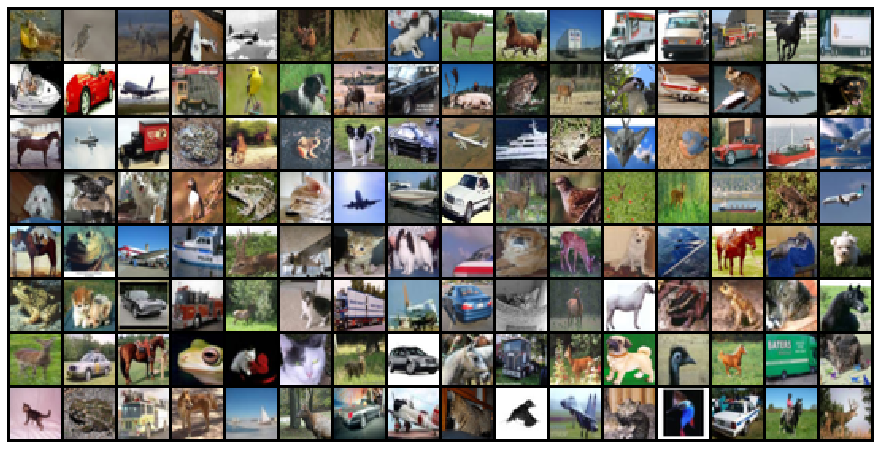

In [12]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
torch.cuda.is_available()

False

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [25]:
input_size = 3*32*32
output_size = 10

In [26]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [44]:
model = to_device(CIFAR10Model(), device)

In [45]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3041505813598633, 'val_acc': 0.10197611153125763}]

In [46]:
history += fit(10, 1e-1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.8426, val_acc: 0.3342
Epoch [1], val_loss: 1.7504, val_acc: 0.3718
Epoch [2], val_loss: 1.6855, val_acc: 0.3923
Epoch [3], val_loss: 1.6813, val_acc: 0.4086
Epoch [4], val_loss: 1.6651, val_acc: 0.4093
Epoch [5], val_loss: 1.5641, val_acc: 0.4517
Epoch [6], val_loss: 1.7518, val_acc: 0.3700
Epoch [7], val_loss: 1.5154, val_acc: 0.4654
Epoch [8], val_loss: 1.5506, val_acc: 0.4547
Epoch [9], val_loss: 1.7772, val_acc: 0.4057


In [48]:
history += fit(10, 1e-2, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3856, val_acc: 0.5242
Epoch [1], val_loss: 1.3810, val_acc: 0.5240
Epoch [2], val_loss: 1.3795, val_acc: 0.5267
Epoch [3], val_loss: 1.3730, val_acc: 0.5304
Epoch [4], val_loss: 1.3675, val_acc: 0.5290
Epoch [5], val_loss: 1.3651, val_acc: 0.5304
Epoch [6], val_loss: 1.3671, val_acc: 0.5261
Epoch [7], val_loss: 1.3609, val_acc: 0.5305
Epoch [8], val_loss: 1.3612, val_acc: 0.5249
Epoch [9], val_loss: 1.3649, val_acc: 0.5333


{'val_loss': 1.3561089038848877, 'val_acc': 0.520312488079071}

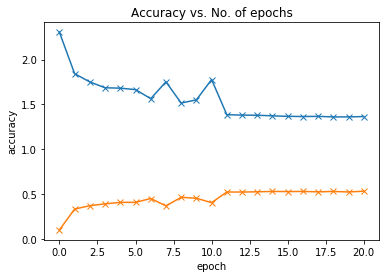

In [49]:
plot_losses(history)
plot_accuracies(history)
evaluate(model, test_loader)